In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

# --- 配置 ---
INDEX_PATH = Path("../第3问_CNN/index.csv")
TARGET_DOMAIN_PREFIX = "../第3问_CNN/cleaned/目标域/"

# --- 定义我们要查找的列名映射 ---
# {'标准名': ['可能存在的列名片段1', '片段2', ...]}
COLUMN_SEARCH_MAP = {
    'csv_path': ['csv_path'],
    'fs': ['赫兹', '采样率'],
    'rpm': ['转速'],
    'label': ['故障类']
}

# --- 加载与清洗索引文件 ---
print(f"正在从 '{INDEX_PATH}' 加载索引文件...")

try:
    # 尝试用 utf-8-sig 编码，这能更好地处理带BOM的CSV文件
    df_index = pd.read_csv(INDEX_PATH, encoding='utf-8-sig')
    
    # 原始列名，用于调试
    original_cols = df_index.columns.tolist()
    # 清洗列名，转为小写并去除首尾空格
    df_index.columns = [str(c).strip().lower() for c in df_index.columns]

    found_cols = {}
    for standard_name, possible_names in COLUMN_SEARCH_MAP.items():
        for col in df_index.columns:
            # 检查任一可能的名字是否存在于列名中
            if any(p_name in col for p_name in possible_names):
                found_cols[standard_name] = col
                break # 找到后就跳出内层循环
    
    # 检查是否所有必要的列都找到了
    required_keys = ['csv_path', 'fs', 'rpm', 'label']
    if not all(key in found_cols for key in required_keys):
        missing = [key for key in required_keys if key not in found_cols]
        raise ValueError(f"错误：索引文件中缺少必要的列: {missing}。 原始列为: {original_cols}")

    # 筛选我们需要的列
    df_filtered = df_index[list(found_cols.values())].copy()
    
    # 构建重命名映射并执行
    rename_dict = {v: k for k, v in found_cols.items()}
    df_filtered.rename(columns=rename_dict, inplace=True)

    # 转换数据类型，无效值设为 NaN
    df_filtered['fs'] = pd.to_numeric(df_filtered['fs'], errors='coerce')
    df_filtered['rpm'] = pd.to_numeric(df_filtered['rpm'], errors='coerce')

    # --- 分离源域和目标域 ---
    df_filtered['domain'] = np.where(df_filtered['csv_path'].str.startswith(TARGET_DOMAIN_PREFIX), 'target', 'source')
    
    # 暂时只处理源域数据
    df_source = df_filtered[df_filtered['domain'] == 'source'].copy()

    print("\n索引加载并清洗完成！")
    print(f"\n分离出源域和目标域：\n{df_filtered['domain'].value_counts()}")
    print("\n已筛选出源域数据进行处理，预览:")
    display(df_source.head())

except FileNotFoundError:
    print(f"错误：无法在 '{INDEX_PATH}' 找到索引文件。请检查路径是否正确。")
except Exception as e:
    print(f"发生错误: {e}")

正在从 '../第3问_CNN/index.csv' 加载索引文件...

索引加载并清洗完成！

分离出源域和目标域：
domain
source    161
target     16
Name: count, dtype: int64

已筛选出源域数据进行处理，预览:


,csv_path,fs,rpm,label,domain
0,../第3问_CNN/cleaned/48kHz_Normal_data/N_0.csv,48000,1796,N,source
1,../第3问_CNN/cleaned/48kHz_Normal_data/N_1_(1772...,48000,1772,N,source
2,../第3问_CNN/cleaned/48kHz_Normal_data/N_2_(1750...,48000,1750,N,source
3,../第3问_CNN/cleaned/48kHz_Normal_data/N_3.csv,48000,1725,N,source
20,../第3问_CNN/cleaned/12kHz_DE_data/B/0007/B007_0...,12000,1798,B,source


In [2]:
import numpy as np
from pathlib import Path

def select_channel_from_file(file_path: str) -> np.ndarray | None:
    """
    Reads data from a given CSV file and selects a single channel based on the priority DE -> FE -> BA.
    
    Args:
        file_path (str): The path to the CSV file.

    Returns:
        np.ndarray | None: A 1D NumPy array of the signal data if successful, otherwise None.
    """
    try:
        p = Path(file_path)
        if not p.exists():
            print(f"Error: File not found at {file_path}")
            return None
            
        df_signal = pd.read_csv(p)
        
        # Standardize column names to uppercase for consistent checking
        df_signal.columns = [str(c).strip().upper() for c in df_signal.columns]
        
        signal_data = None
        if 'DE' in df_signal.columns:
            signal_data = df_signal['DE'].values
        elif 'FE' in df_signal.columns:
            signal_data = df_signal['FE'].values
        elif 'BA' in df_signal.columns:
            signal_data = df_signal['BA'].values
        else:
            print(f"Warning: No priority channel (DE, FE, BA) found in {p.name}.")
            return None
        
        # Ensure data is float and handle potential non-numeric values
        signal_data = pd.to_numeric(signal_data, errors='coerce')
        
        # Check for NaNs that may have been introduced by 'coerce'
        nan_count = np.isnan(signal_data).sum()
        if nan_count > 0:
            print(f"Warning: Found and filled {nan_count} non-numeric values in {p.name}.")
            # A simple strategy: fill NaNs with the mean of the valid points
            mean_val = np.nanmean(signal_data)
            signal_data = np.nan_to_num(signal_data, nan=mean_val)
            
        return signal_data.astype(float)

    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")
        return None

# --- Function Test ---
print("--- Testing the Channel Selector Function ---")

# Get the first file path from our source dataframe
first_row = df_source.iloc[0]
file_to_test = first_row['csv_path']

print(f"Attempting to load signal from: {file_to_test}")

# Call the function
signal_array = select_channel_from_file(file_to_test)

if signal_array is not None:
    print("\n✅ Success!")
    print(f"   Signal Length: {len(signal_array)}")
    print(f"   Data Type: {signal_array.dtype}")
    print(f"   First 5 values: {signal_array[:5]}")
else:
    print("\n❌ Failed to load signal.")

--- Testing the Channel Selector Function ---
Attempting to load signal from: ../第3问_CNN/cleaned/48kHz_Normal_data/N_0.csv

✅ Success!
   Signal Length: 243938
   Data Type: float64
   First 5 values: [ 0.04063871  0.07610333  0.08715994  0.04606271 -0.01714775]


In [3]:
from scipy.signal import resample

# --- Configuration ---
TARGET_FS = 32000 # Hz

def resample_signal(signal_array: np.ndarray, original_fs: int, target_fs: int = TARGET_FS) -> np.ndarray:
    """
    Resamples a signal to a target sampling frequency.
    
    Args:
        signal_array (np.ndarray): The input 1D signal array.
        original_fs (int): The original sampling frequency of the signal.
        target_fs (int): The target sampling frequency.

    Returns:
        np.ndarray: The resampled signal array.
    """
    if original_fs == target_fs:
        # No resampling needed if the rates are already the same
        return signal_array
        
    # Calculate the number of samples in the new signal
    duration = len(signal_array) / original_fs
    num_target_samples = int(duration * target_fs)
    
    # Perform resampling
    resampled_signal = resample(signal_array, num_target_samples)
    
    return resampled_signal.astype(np.float32) # Use float32 to save memory

# --- Function Test ---
print("--- Testing the Resampling Function ---")

# We use the signal_array loaded in the previous cell
# We need its original sampling rate from our dataframe
original_sampling_rate = first_row['fs']

print(f"Original FS: {original_sampling_rate} Hz, Original Length: {len(signal_array)}")
print(f"Target FS: {TARGET_FS} Hz")

# Call the resampling function
resampled_array = resample_signal(signal_array, original_fs=original_sampling_rate)

if resampled_array is not None:
    print("\n✅ Success!")
    print(f"   New Resampled Length: {len(resampled_array)}")
    print(f"   Data Type: {resampled_array.dtype}")
    print(f"   First 5 values: {resampled_array[:5]}")
else:
    print("\n❌ Failed to resample signal.")

--- Testing the Resampling Function ---
Original FS: 48000 Hz, Original Length: 243938
Target FS: 32000 Hz

✅ Success!
   New Resampled Length: 162625
   Data Type: float32
   First 5 values: [ 0.04457123  0.08584069  0.04788527 -0.04789851 -0.08382716]


In [4]:
import numpy as np

# --- Configuration ---
PPR = 720  # Points Per Revolution. A higher value captures more detail. 720 is a good start.

# 只需要更新 angle_sync 函数即可

def angle_sync(signal_array: np.ndarray, rpm: float, fs: int = TARGET_FS, ppr: int = PPR) -> np.ndarray | None:
    """
    Performs angular synchronization on a time-domain signal.
    """
    # --- 新增的检查 ---
    # 如果输入的信号数组是空的，直接返回None
    if signal_array.size == 0:
        print("Warning: Received an empty signal array. Skipping angular sync.")
        return None

    if rpm <= 0 or not np.isfinite(rpm):
        print(f"Warning: Invalid RPM ({rpm}). Skipping angular sync.")
        return None
        
    # Rotational frequency in Hz (revolutions per second)
    fr = rpm / 60.0
    
    # Original time vector for the input signal
    t_original = np.arange(len(signal_array)) / fs
    
    # Calculate the total number of full revolutions in the signal
    total_revs = t_original[-1] * fr
    if total_revs < 1:
        print(f"Warning: Signal is too short ({total_revs:.2f} revs) for angular sync. Need at least 1 revolution.")
        return None
        
    # (函数的其余部分保持不变)
    num_full_revs = int(np.floor(total_revs))
    total_angle = 2 * np.pi * num_full_revs
    num_new_points = num_full_revs * ppr
    angle_new = np.linspace(0, total_angle, num=num_new_points, endpoint=False)
    angle_original = 2 * np.pi * fr * t_original
    angle_domain_signal = np.interp(angle_new, angle_original, signal_array)
    
    return angle_domain_signal.astype(np.float32)
# --- Function Test ---
print("--- Testing the Angular Synchronization Function ---")

# We use the resampled_array from the previous cell
# We need its original RPM from our dataframe
rpm_value = first_row['rpm']

print(f"Input Signal Length: {len(resampled_array)}, RPM: {rpm_value}")

# Call the angular sync function
angle_synced_array = angle_sync(resampled_array, rpm=rpm_value)

if angle_synced_array is not None:
    print("\n✅ Success!")
    print(f"   New Angle-Domain Length: {len(angle_synced_array)}")
    print(f"   Data Type: {angle_synced_array.dtype}")
    print(f"   First 5 values: {angle_synced_array[:5]}")
else:
    print("\n❌ Failed to perform angular synchronization.")

--- Testing the Angular Synchronization Function ---
Input Signal Length: 162625, RPM: 1796

✅ Success!
   New Angle-Domain Length: 109440
   Data Type: float32
   First 5 values: [ 0.04457123  0.06744063 -0.04498304 -0.07470046 -0.06240746]


--- 测试STFT图像生成函数 ---

✅ 成功生成STFT图像!
   图像尺寸 (阶次bins, 时间steps): (129, 1711)
   数据类型: float32


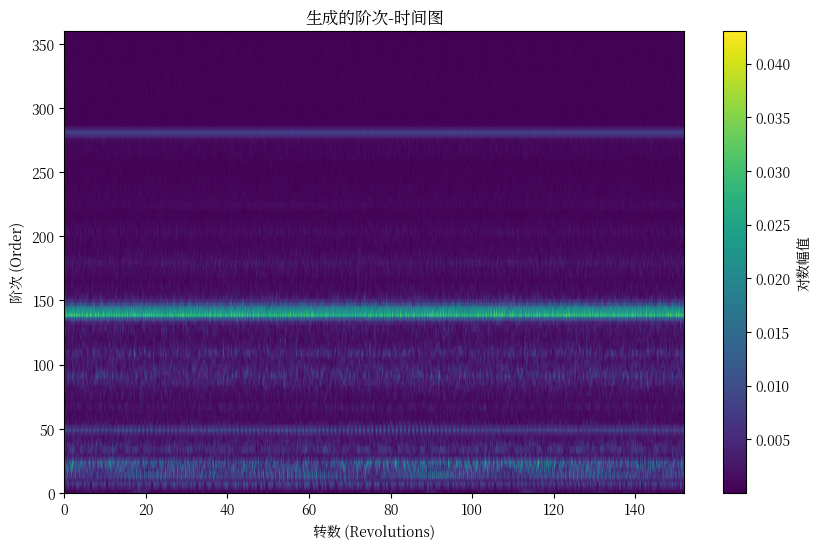

In [5]:
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
myfont = fm.FontProperties(fname="/usr/share/fonts/opentype/noto/NotoSerifCJK-Bold.ttc")
plt.rcParams['font.family'] = myfont.get_name()
plt.rcParams['axes.unicode_minus'] = False
# --- 配置 ---
# STFT参数，这些参数可以调整以改变图像的分辨率
N_PER_SEG = 256  # STFT每一段的长度，可以理解为图像的“垂直分辨率”
N_OVERLAP = 192  # 每一段之间的重叠部分，通常是 N_PER_SEG 的 50% 到 75%

def generate_stft_image(angle_domain_signal: np.ndarray, ppr: int = PPR) -> np.ndarray:
    """
    使用STFT将一维角度域信号转换为二维阶次-时间图。
    
    Args:
        angle_domain_signal (np.ndarray): 输入的一维角度域信号。
        ppr (int): 每转点数，在角度域中，它扮演了“采样率”的角色。

    Returns:
        np.ndarray: 代表信号的二维图像矩阵。
    """
    # 在角度域信号上进行STFT
    # 这里的 fs 参数就是我们的 ppr，因为单位是“点/转”
    # 输出的频率 f 的单位将是“阶次 (Order)”
    orders, _, Zxx = stft(
        angle_domain_signal,
        fs=ppr,
        nperseg=N_PER_SEG,
        noverlap=N_OVERLAP
    )
    
    # 我们只需要幅值，并进行对数变换以压缩动态范围，便于模型学习
    # np.log1p(x) 等同于 np.log(1+x)，可以避免对0取对数
    stft_image = np.log1p(np.abs(Zxx))
    
    return stft_image.astype(np.float32)

# --- 函数测试 ---
print("--- 测试STFT图像生成函数 ---")

# 使用上一单元格生成的 angle_synced_array
stft_result_image = generate_stft_image(angle_synced_array)

if stft_result_image is not None:
    print("\n✅ 成功生成STFT图像!")
    print(f"   图像尺寸 (阶次bins, 时间steps): {stft_result_image.shape}")
    print(f"   数据类型: {stft_result_image.dtype}")
    
    # --- 可视化 ---
    plt.figure(figsize=(10, 6))
    plt.imshow(stft_result_image, aspect='auto', origin='lower',
               extent=[0, len(angle_synced_array)/PPR, 0, PPR/2])
    plt.colorbar(label='对数幅值')
    plt.xlabel('转数 (Revolutions)')
    plt.ylabel('阶次 (Order)')
    plt.title('生成的阶次-时间图')
    plt.show()
    
else:
    print("\n❌ 生成STFT图像失败。")

In [6]:
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import os

# --- 配置 ---
# 创建一个目录来存放我们生成的图像
OUTPUT_DIR = Path("../第3问_CNN/processed_images")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 批量处理循环 ---
processed_metadata = []  # 用于存储成功处理的文件的信息

# 使用 tqdm 来显示进度条
for index, row in tqdm(df_source.iterrows(), total=len(df_source), desc="正在处理源域文件"):
    
    # 获取当前文件的元数据
    file_path_str = row['csv_path']
    original_fs = row['fs']
    rpm = row['rpm']
    label = row['label']

    # --- Step 1: 智能通道选择 ---
    signal = select_channel_from_file(file_path_str)
    if signal is None:
        print(f"跳过：无法从 {file_path_str} 加载信号")
        continue

    # --- Step 2: 重采样 ---
    resampled = resample_signal(signal, original_fs=original_fs)
    if resampled is None:
        print(f"跳过：重采样失败 {file_path_str}")
        continue

    # --- Step 3: 角同步 ---
    angle_synced = angle_sync(resampled, rpm=rpm)
    if angle_synced is None:
        print(f"跳过：角同步失败 {file_path_str}")
        continue
        
    # --- Step 4: 生成STFT图像 ---
    stft_image = generate_stft_image(angle_synced)
    if stft_image is None:
        print(f"跳过：STFT图像生成失败 {file_path_str}")
        continue
        
    # --- Step 5: 保存图像并记录元数据 ---
    # 创建一个有意义的文件名
    original_stem = Path(file_path_str).stem
    output_filename = f"{original_stem}.npy"
    output_path = OUTPUT_DIR / output_filename
    
    # 保存为 .npy 文件，这比图片格式更能保留原始数据
    np.save(output_path, stft_image)
    
    # 记录成功处理文件的信息
    processed_metadata.append({
        'image_path': str(output_path),
        'original_file': file_path_str,
        'label': label,
        'rpm': rpm,
        'original_fs': original_fs
    })

# --- 创建最终的元数据文件 ---
df_processed = pd.DataFrame(processed_metadata)
manifest_path = OUTPUT_DIR.parent / "source_manifest.csv"
df_processed.to_csv(manifest_path, index=False, encoding='utf-8-sig')

print(f"\n🎉 全部处理完成！")
print(f"成功处理了 {len(df_processed)} / {len(df_source)} 个文件。")
print(f"所有图像已保存至: {OUTPUT_DIR}")
print(f"新的元数据文件已保存至: {manifest_path}")
display(df_processed.head())

正在处理源域文件:   0%|          | 0/161 [00:00<?, ?it/s]


🎉 全部处理完成！
成功处理了 161 / 161 个文件。
所有图像已保存至: ../第3问_CNN/processed_images
新的元数据文件已保存至: ../第3问_CNN/source_manifest.csv


,image_path,original_file,label,rpm,original_fs
0,../第3问_CNN/processed_images/N_0.npy,../第3问_CNN/cleaned/48kHz_Normal_data/N_0.csv,N,1796,48000
1,../第3问_CNN/processed_images/N_1_(1772rpm).npy,../第3问_CNN/cleaned/48kHz_Normal_data/N_1_(1772...,N,1772,48000
2,../第3问_CNN/processed_images/N_2_(1750rpm).npy,../第3问_CNN/cleaned/48kHz_Normal_data/N_2_(1750...,N,1750,48000
3,../第3问_CNN/processed_images/N_3.npy,../第3问_CNN/cleaned/48kHz_Normal_data/N_3.csv,N,1725,48000
4,../第3问_CNN/processed_images/B007_0.npy,../第3问_CNN/cleaned/12kHz_DE_data/B/0007/B007_0...,B,1798,12000


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np
import gc

from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from tqdm.notebook import tqdm
import torch.nn.functional as F

# ==============================================================================
# 单元格 1: 所有定义（类和函数）
# ==============================================================================

# --- 配置 ---
MANIFEST_PATH = Path("../第3问_CNN/source_manifest.csv")
BATCH_SIZE = 32
FIXED_WIDTH = 4096
KNOWN_IMAGE_SHAPE = (1, 129, 4096) # (Channels, Height, Width)

# --- Dataset 定义 ---
class BearingDataset(Dataset):
    def __init__(self, manifest_path: Path, fixed_width: int):
        self.manifest = pd.read_csv(manifest_path)
        self.fixed_width = fixed_width
        self.classes = sorted(self.manifest['label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
    def __len__(self):
        return len(self.manifest)
    def _pad_or_truncate(self, image: np.ndarray) -> np.ndarray:
        height, width = image.shape
        if width > self.fixed_width: return image[:, :self.fixed_width]
        elif width < self.fixed_width:
            padding = self.fixed_width - width
            return np.pad(image, ((0, 0), (0, padding)), mode='constant', constant_values=0)
        return image
    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        image = np.load(row['image_path'])
        image = self._pad_or_truncate(image)
        label_idx = self.class_to_idx[row['label']]
        return torch.from_numpy(image).unsqueeze(0).float(), torch.tensor(label_idx, dtype=torch.long)

# --- CNN 模型定义 ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, input_shape: tuple):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=(3, 5), stride=1, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 4)),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 4)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=(2, 4))
        )
        dummy_input = torch.randn(1, *input_shape)
        flattened_size = self.features(dummy_input).view(1, -1).size(1)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=128),
            nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# ==============================================================================
# 单元格 2: 数据加载和训练执行
# ==============================================================================

# --- 1. 数据加载器设置 (带过采样) ---
print("--- 准备数据集和加载器 ---")
source_dataset = BearingDataset(manifest_path=MANIFEST_PATH, fixed_width=FIXED_WIDTH)
print(f"找到的类别: {source_dataset.class_to_idx}")

labels_list = pd.read_csv(MANIFEST_PATH)['label'].tolist()
class_names = source_dataset.classes
class_weights = compute_class_weight('balanced', classes=np.array(class_names), y=labels_list)
class_weights_dict = {cls: weight for cls, weight in zip(class_names, class_weights)}
sample_weights = [class_weights_dict[label] for label in labels_list]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

oversample_loader = DataLoader(
    dataset=source_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2
)
print("✅ 带过采样功能的数据加载器准备就绪！")

# --- 2. 训练执行 ---
print("\n--- 开始训练 (最终整合版) ---")
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

model = SimpleCNN(num_classes=len(source_dataset.classes), input_shape=KNOWN_IMAGE_SHAPE)
model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(oversample_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    epoch_loss = running_loss / len(oversample_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} 完成, 平均损失: {epoch_loss:.4f}")

    del images, labels, outputs
    torch.cuda.empty_cache()  # 清理 GPU 内存
    gc.collect()  # 强制垃圾回收

print("\n--- 训练完成 ---")
SAVE_PATH = "./source_domain_model_oversampled.pth"
torch.save(model.state_dict(), SAVE_PATH)
print(f"优化后的模型已保存至: {SAVE_PATH}")

--- 准备数据集和加载器 ---
找到的类别: {'B': 0, 'IR': 1, 'N': 2, 'OR': 3}
✅ 带过采样功能的数据加载器准备就绪！

--- 开始训练 (最终整合版) ---
使用设备: cuda


Epoch 1/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/50 完成, 平均损失: 7.6564


Epoch 2/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/50 完成, 平均损失: 4.0125


Epoch 3/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/50 完成, 平均损失: 2.4687


Epoch 4/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/50 完成, 平均损失: 2.1196


Epoch 5/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/50 完成, 平均损失: 2.2502


Epoch 6/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/50 完成, 平均损失: 1.9846


Epoch 7/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/50 完成, 平均损失: 1.3070


Epoch 8/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/50 完成, 平均损失: 0.9588


Epoch 9/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/50 完成, 平均损失: 0.4661


Epoch 10/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/50 完成, 平均损失: 0.6920


Epoch 11/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/50 完成, 平均损失: 1.1975


Epoch 12/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/50 完成, 平均损失: 0.4490


Epoch 13/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/50 完成, 平均损失: 1.0712


Epoch 14/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/50 完成, 平均损失: 0.6291


Epoch 15/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/50 完成, 平均损失: 0.8112


Epoch 16/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 16/50 完成, 平均损失: 1.3450


Epoch 17/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 17/50 完成, 平均损失: 1.1442


Epoch 18/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 18/50 完成, 平均损失: 0.6993


Epoch 19/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 19/50 完成, 平均损失: 1.4102


Epoch 20/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 20/50 完成, 平均损失: 0.5519


Epoch 21/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 21/50 完成, 平均损失: 0.8708


Epoch 22/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 22/50 完成, 平均损失: 0.9634


Epoch 23/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 23/50 完成, 平均损失: 0.4443


Epoch 24/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 24/50 完成, 平均损失: 0.5074


Epoch 25/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 25/50 完成, 平均损失: 0.4119


Epoch 26/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 26/50 完成, 平均损失: 0.3855


Epoch 27/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 27/50 完成, 平均损失: 0.3433


Epoch 28/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 28/50 完成, 平均损失: 0.4633


Epoch 29/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 29/50 完成, 平均损失: 0.8657


Epoch 30/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 30/50 完成, 平均损失: 0.4587


Epoch 31/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 31/50 完成, 平均损失: 0.4465


Epoch 32/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 32/50 完成, 平均损失: 0.6846


Epoch 33/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 33/50 完成, 平均损失: 0.4695


Epoch 34/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 34/50 完成, 平均损失: 0.4394


Epoch 35/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 35/50 完成, 平均损失: 0.4327


Epoch 36/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 36/50 完成, 平均损失: 0.5964


Epoch 37/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 37/50 完成, 平均损失: 0.3581


Epoch 38/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 38/50 完成, 平均损失: 0.3309


Epoch 39/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 39/50 完成, 平均损失: 0.4264


Epoch 40/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 40/50 完成, 平均损失: 0.4097


Epoch 41/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 41/50 完成, 平均损失: 0.4222


Epoch 42/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 42/50 完成, 平均损失: 0.3608


Epoch 43/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 43/50 完成, 平均损失: 0.4809


Epoch 44/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 44/50 完成, 平均损失: 0.5732


Epoch 45/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 45/50 完成, 平均损失: 0.6922


Epoch 46/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 46/50 完成, 平均损失: 0.3217


Epoch 47/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 47/50 完成, 平均损失: 0.3146


Epoch 48/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 48/50 完成, 平均损失: 0.3115


Epoch 49/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 49/50 完成, 平均损失: 0.4476


Epoch 50/50:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 50/50 完成, 平均损失: 0.5564

--- 训练完成 ---
优化后的模型已保存至: ./source_domain_model_oversampled.pth


--- 加载模型并准备评估 ---


正在评估模型:   0%|          | 0/6 [00:00<?, ?it/s]


模型在源域上的总体准确率: 98.14%

分类报告:
              precision    recall  f1-score   support

           B       0.96      0.98      0.97        47
          IR       0.98      1.00      0.99        43
           N       1.00      1.00      1.00        40
          OR       1.00      0.94      0.97        31

    accuracy                           0.98       161
   macro avg       0.98      0.98      0.98       161
weighted avg       0.98      0.98      0.98       161



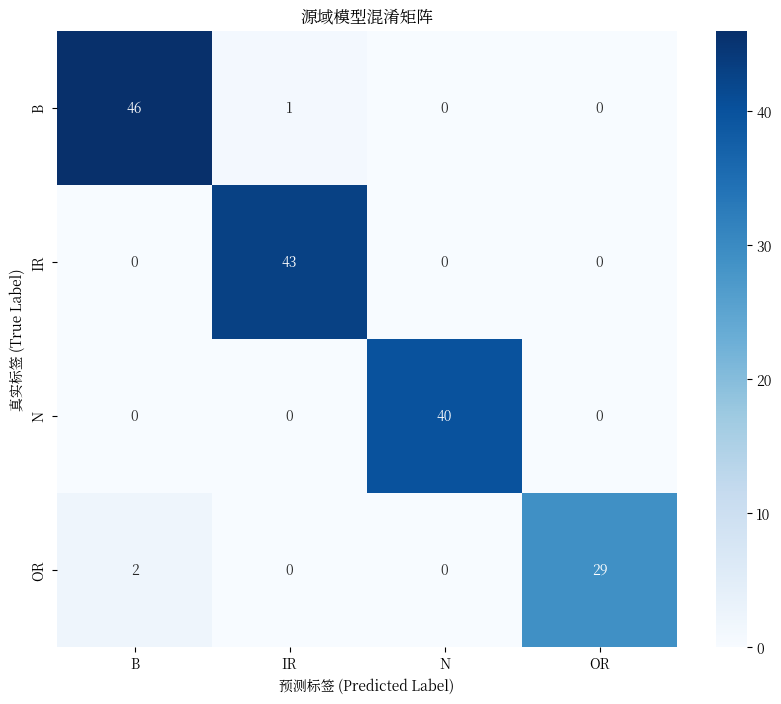

In [8]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. 加载训练好的模型 ---
print("--- 加载模型并准备评估 ---")
images_batch, _ = next(iter(oversample_loader))
# 确保模型结构和之前定义的一致
# 我们需要重新实例化模型，然后加载权重
eval_model = SimpleCNN(num_classes=len(source_dataset.classes), input_shape=tuple(images_batch.shape[1:]))
eval_model.load_state_dict(torch.load("../第3问_CNN/source_domain_model_oversampled.pth"))

# 将模型移动到设备并设置为评估模式
eval_model.to(device)
eval_model.eval() # 关键一步：将模型设置为评估模式（会关闭Dropout等）

# --- 2. 在源域数据上进行预测 ---
all_preds = []
all_labels = []

# torch.no_grad() 上下文管理器可以禁用梯度计算，节省内存和计算资源
with torch.no_grad():
    for images, labels in tqdm(oversample_loader, desc="正在评估模型"):
        images = images.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = eval_model(images)
        
        # 获取预测结果（概率最高的类别）
        _, predicted = torch.max(outputs.data, 1)
        
        # 收集所有预测和真实标签
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# --- 3. 计算并打印评估指标 ---
# 获取类别名称，用于报告和图表
class_names = source_dataset.classes

accuracy = accuracy_score(all_labels, all_preds)
print(f"\n模型在源域上的总体准确率: {accuracy * 100:.2f}%")

print("\n分类报告:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))


# --- 4. 绘制混淆矩阵 ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('源域模型混淆矩阵')
plt.ylabel('真实标签 (True Label)')
plt.xlabel('预测标签 (Predicted Label)')
plt.show()

In [23]:
import torch
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import numpy as np
from scipy.signal import resample, stft
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F


# --- 1. 所有辅助函数定义 ---

def select_channel_from_file(file_path: str) -> np.ndarray | None:
    """
    从CSV读取信号，优先级为 DE -> FE -> BA -> NO
    """
    try:
        p = Path(file_path)
        if not p.exists(): return None
        df_signal = pd.read_csv(p)
        df_signal.columns = [str(c).strip().upper() for c in df_signal.columns]
        
        signal_data = None
        # 依次检查每个优先级的列是否存在且包含有效数据
        if 'DE' in df_signal.columns and df_signal['DE'].notna().any():
            signal_data = df_signal['DE'].values
        elif 'FE' in df_signal.columns and df_signal['FE'].notna().any():
            signal_data = df_signal['FE'].values
        elif 'BA' in df_signal.columns and df_signal['BA'].notna().any():
            signal_data = df_signal['BA'].values
        elif 'NO' in df_signal.columns and df_signal['NO'].notna().any(): # 关键修正：添加对NO列的回退
            # print(f"Info: File {p.name} is using 'NO' column as signal.")
            signal_data = df_signal['NO'].values
        else:
            return None # 如果所有列都无效，则返回None
            
        signal_data = pd.to_numeric(signal_data, errors='coerce')
        if np.isnan(signal_data).sum() > 0:
            mean_val = np.nanmean(signal_data)
            signal_data = np.nan_to_num(signal_data, nan=mean_val)
        return signal_data.astype(float)
    except Exception:
        return None

# (其余辅助函数与之前相同)
def resample_signal(signal_array: np.ndarray, original_fs: int, target_fs: int = 32000) -> np.ndarray:
    if original_fs == target_fs: return signal_array
    duration = len(signal_array) / original_fs
    num_target_samples = int(duration * target_fs)
    if num_target_samples == 0: return np.array([])
    return resample(signal_array, num_target_samples).astype(np.float32)

def angle_sync(signal_array: np.ndarray, rpm: float, fs: int = 32000, ppr: int = 720) -> np.ndarray | None:
    if signal_array.size == 0: return None
    if rpm <= 0 or not np.isfinite(rpm): return None
    fr = rpm / 60.0
    t_original = np.arange(len(signal_array)) / fs
    if len(t_original) == 0: return None
    total_revs = t_original[-1] * fr
    if total_revs < 1: return None
    num_full_revs = int(np.floor(total_revs))
    total_angle = 2 * np.pi * num_full_revs
    num_new_points = num_full_revs * ppr
    angle_new = np.linspace(0, total_angle, num=num_new_points, endpoint=False)
    angle_original = 2 * np.pi * fr * t_original
    angle_domain_signal = np.interp(angle_new, angle_original, signal_array)
    return angle_domain_signal.astype(np.float32)

def generate_stft_image(angle_domain_signal: np.ndarray, ppr: int = 720) -> np.ndarray:
    orders, _, Zxx = stft(angle_domain_signal, fs=ppr, nperseg=256, noverlap=192)
    return np.log1p(np.abs(Zxx)).astype(np.float32)

def preprocess_single_file(file_path, original_fs, rpm):
    signal = select_channel_from_file(file_path)
    if signal is None: return None
    resampled = resample_signal(signal, original_fs=original_fs)
    if resampled is None or resampled.size==0: return None
    angle_synced = angle_sync(resampled, rpm=rpm)
    if angle_synced is None: return None
    stft_image = generate_stft_image(angle_synced)
    if stft_image is None: return None
    height, width = stft_image.shape
    if width > 4096: stft_image = stft_image[:, :4096]
    elif width < 4096:
        padding_needed = 4096 - width
        stft_image = np.pad(stft_image, ((0, 0), (0, padding_needed)), mode='constant', constant_values=0)
    return stft_image

# --- 2. 主执行流程 ---
print("--- 开始最终诊断流程 (已更新NO列逻辑) ---")

# a. 准备目标域数据
df_target = df_filtered[df_filtered['domain'] == 'target'].copy()
print(f"找到 {len(df_target)} 个目标域文件进行诊断。")

# b. 加载模型 (需要重新实例化模型，以防之前的定义丢失)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = SimpleCNN(num_classes=len(source_dataset.classes), input_shape=tuple(images_batch.shape[1:]))
MODEL_PATH = "./source_domain_model_oversampled.pth"
final_model.load_state_dict(torch.load(MODEL_PATH))
final_model.to(device)
final_model.eval()
print(f"成功加载模型: {MODEL_PATH}")

# c. 循环处理并预测
predictions = []
idx_to_class = {i: cls for cls, i in source_dataset.class_to_idx.items()}

with torch.no_grad():
    for index, row in tqdm(df_target.iterrows(), total=len(df_target), desc="正在诊断目标域文件"):
        file_path_str, original_fs, rpm = row['csv_path'], row['fs'], row['rpm']
        image = preprocess_single_file(file_path_str, original_fs, rpm)
        if image is None:
            predicted_label = "处理失败"
        else:
            image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float().to(device)
            output = final_model(image_tensor)
            _, predicted_idx = torch.max(output.data, 1)
            predicted_label = idx_to_class[predicted_idx.item()]
        predictions.append({'target_file': Path(file_path_str).name, 'predicted_fault_type': predicted_label})
        del image, image_tensor, output
        torch.cuda.empty_cache()  # 清理 GPU 内存
        gc.collect()  # 强制垃圾回收

# d. 展示结果
df_results = pd.DataFrame(predictions)
print("\n--- 目标域故障诊断结果 ---")
display(df_results)

--- 开始最终诊断流程 (已更新NO列逻辑) ---
找到 16 个目标域文件进行诊断。
成功加载模型: ./source_domain_model_oversampled.pth


正在诊断目标域文件:   0%|          | 0/16 [00:00<?, ?it/s]


--- 目标域故障诊断结果 ---


,target_file,predicted_fault_type
0,A.csv,N
1,B.csv,IR
2,C.csv,IR
3,D.csv,IR
4,E.csv,OR
5,F.csv,IR
6,G.csv,IR
7,H.csv,IR
8,I.csv,IR
9,J.csv,IR


In [ ]:
# --- 配置 ---
TARGET_OUTPUT_DIR = Path("./processed_images/target")
TARGET_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- 批量处理目标域文件 ---
target_processed_metadata = []
for index, row in tqdm(df_target.iterrows(), total=len(df_target), desc="正在处理目标域文件"):
    file_path_str, original_fs, rpm = row['csv_path'], row['fs'], row['rpm']
    
    # 使用我们之前定义好的完整预处理函数
    image = preprocess_single_file(file_path_str, original_fs, rpm)
    
    if image is not None:
        original_stem = Path(file_path_str).stem
        output_filename = f"{original_stem}.npy"
        output_path = TARGET_OUTPUT_DIR / output_filename
        np.save(output_path, image)
        
        target_processed_metadata.append({
            'image_path': str(output_path),
            'original_file': file_path_str
        })

# --- 创建目标域的元数据文件 ---
df_target_processed = pd.DataFrame(target_processed_metadata)
target_manifest_path = TARGET_OUTPUT_DIR.parent / "target_manifest.csv"
df_target_processed.to_csv(target_manifest_path, index=False, encoding='utf-8-sig')

print(f"\n🎉 目标域数据处理完成！")
print(f"成功处理了 {len(df_target_processed)} / {len(df_target)} 个文件。")
print(f"图像已保存至: {TARGET_OUTPUT_DIR}")
print(f"元数据文件已保存至: {target_manifest_path}")

In [ ]:
# --- 源域加载器 (使用过采样) ---
source_manifest_path = Path("./processed_images/source_manifest.csv")
source_dataset = BearingDataset(manifest_path=source_manifest_path, fixed_width=FIXED_WIDTH)
# (这里的采样器代码来自之前的Cell 7-A，确保它已被执行)
source_labels_list = pd.read_csv(source_manifest_path)['label'].tolist()
class_weights = compute_class_weight('balanced', classes=np.array(source_dataset.classes), y=source_labels_list)
class_weights_dict = {cls: weight for cls, weight in zip(source_dataset.classes, class_weights)}
sample_weights = [class_weights_dict[label] for label in source_labels_list]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

source_loader = DataLoader(
    dataset=source_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=2
)

# --- 目标域加载器 (不需要标签和采样器) ---
class TargetDataset(Dataset): # 为目标域创建一个简单的数据集类
    def __init__(self, manifest_path: Path, fixed_width: int):
        self.manifest = pd.read_csv(manifest_path)
        self.fixed_width = fixed_width
    def __len__(self):
        return len(self.manifest)
    def __getitem__(self, idx):
        # 目标域数据没有标签
        image_path = self.manifest.iloc[idx]['image_path']
        image = np.load(image_path)
        # (这里的pad/truncate逻辑与BearingDataset中一致)
        height, width = image.shape
        if width > self.fixed_width: image = image[:, :self.fixed_width]
        elif width < self.fixed_width:
            padding_needed = self.fixed_width - width
            image = np.pad(image, ((0, 0), (0, padding_needed)), mode='constant', constant_values=0)
        return torch.from_numpy(image).unsqueeze(0).float()

target_dataset = TargetDataset(manifest_path=target_manifest_path, fixed_width=FIXED_WIDTH)
target_loader = DataLoader(
    dataset=target_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 目标域数据可以打乱
    num_workers=2
)

print("✅ 源域和目标域的数据加载器均已准备就绪！")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# --- 1. 定义CORAL损失函数 ---
def coral_loss(source, target):
    """
    计算源域和目标域特征之间的CORAL损失。
    Args:
        source: 源域的特征张量 (batch_size, num_features)
        target: 目标域的特征张量 (batch_size, num_features)
    Returns:
        coral_loss: 计算出的损失值
    """
    d = source.size(1)  # 特征维度

    # a. 计算源域的协方差矩阵
    source_mean = torch.mean(source, 0, keepdim=True)
    source_centered = source - source_mean
    source_cov = (source_centered.t() @ source_centered) / (source.size(0) - 1)

    # b. 计算目标域的协方差矩阵
    target_mean = torch.mean(target, 0, keepdim=True)
    target_centered = target - target_mean
    target_cov = (target_centered.t() @ target_centered) / (target.size(0) - 1)

    # c. 计算两者差异的Frobenius范数的平方
    loss = torch.mean(torch.mul((source_cov - target_cov), (source_cov - target_cov)))
    
    return loss

# --- 2. 训练配置 ---
NUM_EPOCHS = 100 # 域适应训练通常需要足够的轮次
LEARNING_RATE = 0.0001 # 使用稍低的学习率可能更稳定
LAMBDA_CORAL = 1.0 # CORAL损失的权重超参数，可以调整

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 实例化一个全新的模型用于域适应训练
da_model = SimpleCNN(num_classes=len(source_dataset.classes), input_shape=tuple(images_batch.shape[1:]))
da_model.to(device)

# --- 3. 定义损失函数和优化器 ---
classification_criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(da_model.parameters(), lr=LEARNING_RATE)

# --- 4. 编写域适应训练循环 ---
print("\n--- 开始域适应训练 ---")

# 将目标域数据加载器变成一个可以无限循环的迭代器
target_iter = iter(target_loader)

for epoch in range(NUM_EPOCHS):
    da_model.train()
    total_loss, cls_loss_sum, coral_loss_sum = 0.0, 0.0, 0.0
    
    progress_bar = tqdm(source_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    for source_images, source_labels in progress_bar:
        # a. 从目标域加载器中获取一批数据
        try:
            target_images = next(target_iter)
        except StopIteration:
            # 如果目标域数据用完了，就重新创建一个迭代器
            target_iter = iter(target_loader)
            target_images = next(target_iter)

        # b. 将数据移动到设备
        source_images, source_labels = source_images.to(device), source_labels.to(device)
        target_images = target_images.to(device)

        # c. 清零梯度
        optimizer.zero_grad()
        
        # d. 分别通过特征提取器
        source_features = da_model.features(source_images)
        target_features = da_model.features(target_images)
        
        # e. 源域数据通过分类器得到预测
        source_preds = da_model.classifier(source_features.view(source_features.size(0), -1))
        
        # f. 计算分类损失 (只在源域上)
        classification_loss = classification_criterion(source_preds, source_labels)
        
        # g. 计算CORAL损失 (在源域和目标域的特征上)
        # 确保批次大小一致
        min_batch_size = min(source_features.size(0), target_features.size(0))
        c_loss = coral_loss(
            source_features.view(source_features.size(0), -1)[:min_batch_size],
            target_features.view(target_features.size(0), -1)[:min_batch_size]
        )
        
        # h. 计算总损失
        total_loss_batch = classification_loss + LAMBDA_CORAL * c_loss
        
        # i. 反向传播和优化
        total_loss_batch.backward()
        optimizer.step()

        # 统计
        total_loss += total_loss_batch.item()
        cls_loss_sum += classification_loss.item()
        coral_loss_sum += c_loss.item()
        progress_bar.set_postfix({'cls_loss': f'{classification_loss.item():.4f}', 'coral_loss': f'{c_loss.item():.4f}'})

    # 打印周期统计信息
    avg_total_loss = total_loss / len(source_loader)
    avg_cls_loss = cls_loss_sum / len(source_loader)
    avg_coral_loss = coral_loss_sum / len(source_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} 完成, 总损失: {avg_total_loss:.4f} (分类: {avg_cls_loss:.4f}, CORAL: {avg_coral_loss:.4f})")

print("\n--- 域适应训练完成 ---")

# 保存最终的域适应模型
DA_MODEL_SAVE_PATH = "./domain_adapted_model.pth"
torch.save(da_model.state_dict(), DA_MODEL_SAVE_PATH)
print(f"域适应模型已保存至: {DA_MODEL_SAVE_PATH}")